# MiniProyecto 4: Optimización de parámetros

¡Bienvenidos al cuarto (mini)proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando (por última vez) con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es optimizar los parámetros de los algoritmos que usamos en el proyecto pasado.

El dataset es el mismo del proyecto 3. Recordemos que las columnas que se agregan son:

* `barrios_match`: si coincide el barrio publicado con el geográfico vale 1, si no 0.

* `PH`, `apartment`, `house`: variables binarias que indican el tipo de propiedad.

* dummies de barrios: variables binarias con 1 o 0 según el barrio.

La métrica que vamos a usar para medir es RMSE (raíz del error cuadréatico medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

## Pandas - Levantamos el dataset

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)

**Separá** el dataset en entrenamiento (80%) y test (20%) utilizando como target la columna `price_aprox_usd`

In [2]:
# Esto es lo que hace
import numpy as np
np.random.seed(123)
from sklearn.model_selection import train_test_split
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape[0], X_test.shape[0])

5100 1276


## Scikit-learn - Entrenamiento

Para repasar los parámetros de árboles de decisión en Scikit-learn: 

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

En primer lugar veamos como hacer cross validation. Para eso necesitamos definir la cantidad de folds, en este caso vamos a usar 5.

GridSearchCV nos permite testear a través de un espacio de búsqueda de parámetros la mejor combinación posible dado un estimador.

Por ejemplo, en este caso probamos la profundidad máxima y la máxima cantidad de features para hacer los split. Ambos entre 1 y 5.
Recordemos que para hacer la optimización scikit-learn usa la métrica `neg_mean_squared_error` en lugar de `mean_squared_error`.

**Creá** una variable `param_grid` con valores del 1 al 5 para los atributos `max_depth` y `max_features`. 

In [3]:
# Creá en esta celda la variable param_grid

param_grid = [{'max_depth': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5]}]

**Importá** `GridSearchCV` y `DecisionTreeRegressor`.

**Creá** una variable `grid_search` y asignale un `GridSearchCV` que recorra el `param_grid` que creaste con el algoritmos `DecisionTreeRegressor` y el un scoring de `neg_mean_squared_error`

In [4]:
# Importa y crea un GridSearchCV en esta celda

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
tree_reg = DecisionTreeRegressor()

grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                                 scoring='neg_mean_squared_error',
                                 return_train_score=True)

A continuación, realizá el `fit` del `grid_search` con el conjunto de entrenamiento

In [5]:
# Hace el fit de grid search en esta celda
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Revisemos los resultados. Recordemos que no están expresados en RMSE.

In [6]:
grid_search.scorer_

make_scorer(mean_squared_error, greater_is_better=False)

In [7]:
grid_search.cv_results_

{'mean_fit_time': array([0.03260183, 0.02420144, 0.02500148, 0.02520137, 0.02660151,
        0.02600145, 0.02500143, 0.02520137, 0.02480149, 0.02580147,
        0.02540154, 0.02520146, 0.02620158, 0.02700152, 0.02700171,
        0.02500129, 0.02760162, 0.02780161, 0.02780166, 0.02760139,
        0.02680149, 0.0280015 , 0.02840157, 0.02780166, 0.03020172]),
 'std_fit_time': array([9.70819529e-03, 4.00042573e-04, 1.26504558e-03, 7.48379208e-04,
        3.26212973e-03, 3.03340196e-03, 1.16800773e-07, 4.00042545e-04,
        3.99947177e-04, 9.79822223e-04, 7.99918194e-04, 3.99994861e-04,
        9.79793021e-04, 8.94468989e-04, 1.54938885e-03, 1.50789149e-07,
        1.85493378e-03, 1.16615492e-03, 4.00018706e-04, 2.24515882e-03,
        1.72062860e-03, 2.60776625e-03, 1.35667000e-03, 9.79841683e-04,
        2.13549758e-03]),
 'mean_score_time': array([0.0076005 , 0.00760036, 0.00720038, 0.00720043, 0.00740042,
        0.00760045, 0.00740037, 0.0076005 , 0.00760036, 0.00740047,
        0.00

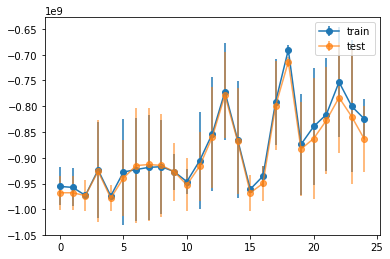

In [8]:
grid_search_df = pd.DataFrame(grid_search.cv_results_)
Parametros = grid_search_df.index
TRAIN_ACC = grid_search_df.mean_train_score
TRAIN_ACC_var =grid_search_df.std_train_score
TEST_ACC = grid_search_df.mean_test_score
TEST_ACC_var = grid_search_df.std_test_score
import matplotlib.pyplot as plt
%matplotlib inline
plt.errorbar(x=Parametros,y=TRAIN_ACC,yerr=TRAIN_ACC_var,fmt='o-',label='train',alpha=1)
plt.errorbar(x=Parametros,y=TEST_ACC,yerr=TEST_ACC_var,fmt='o-',label='test',alpha=0.7)
plt.legend()
plt.show()

**Mostrá** los `grid_scores` obtenidos durante el `grid_search`

In [9]:
# Mostrá los grid_scores en esta celda
grid_search.best_params_

{'max_depth': 4, 'max_features': 4}

De esta manera, el valor con mejor resultado (dado el espacio de búsqueda definido) es `max_depth` 3 y `max_features` 3.

**Mostrá** el mejor score y los mejores parámetros encontrados por `grid_search`

In [10]:
print(grid_search.best_score_)

-713698124.9712428


In [11]:
# Mostrás los resultados en esta celda
grid_search.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=4,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Convertimos a RMSE.

In [12]:
def nmsq2rmse(score):
    return np.round(np.sqrt(-score), 2)

__Encontrar el mejor modelo para el espacio de búsqueda dado__

* `"min_samples_split": [2, 10, 20]`
* `"max_depth": [None, 2, 5, 10, 15]`
* `"min_samples_leaf": [1, 5, 10, 15]`
* `"max_leaf_nodes": [None, 5, 10, 20]`

In [13]:
param_grid = [{'min_samples_split': [2, 10, 20], 'max_depth': [None, 2, 5, 10, 15], 'min_samples_leaf': [1, 5, 10, 15], 'max_leaf_nodes': [None, 5, 10, 20] }]

In [14]:
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                                 scoring='neg_mean_squared_error',
                                 return_train_score=True)

In [15]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'min_samples_split': [2, 10, 20], 'max_depth': [None, 2, 5, 10, 15], 'min_samples_leaf': [1, 5, 10, 15], 'max_leaf_nodes': [None, 5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
print('Best accuracy: %.3f' % grid_search.best_score_)
print('\nBest params:\n', grid_search.best_params_)

Best accuracy: -459407773.744

Best params:
 {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 15, 'min_samples_split': 2}


Recordemos que `GridSearchCV` tiene como parámetro default `refit=True`. Esto significa que luego de hacer la corrida se ajusta el mejor modelo al conjunto de datos de entrada. De esta manera, se puede predecir directamente usando `best_estimator_`.

In [17]:
optimised_decision_tree = grid_search.best_estimator_

__Evaluemos en testing el desempeño de este modelo.__

Como venimos trabajando, el resultado en testing será la medición que usaremos como benchmark para comparar este modelos con otros en el futuro, puesto que no estuvo en contacto con el dataset de test para la calibración.

In [18]:
from sklearn.metrics import mean_squared_error
y_opt_pred = optimised_decision_tree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_opt_pred))
np.round(rmse)

21301.0

Vemos los primeros 10 resultados de la predicción del valor de propiedades.

In [19]:
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_opt_pred)

In [20]:
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [21]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,80000.000,103438.660,23438.660
1,128000.000,135705.882,7705.882
2,150000.000,156075.759,6075.759
3,85000.000,102400.991,17400.991
4,135000.000,135571.622,571.622
5,135000.000,109560.000,25440.000
6,68000.000,75181.250,7181.250
7,110000.000,140444.444,30444.444
8,134000.000,158431.250,24431.250
9,110000.000,76701.202,33298.798
